# DATASET EXPLANATION


- Our goal is to build a multiclassifier model based on deep learning to classify various traffic signs. 
- Dataset that we are using to train the model is **German Traffic Sign Recognition Benchmark**.
- Dataset consists of 43 classes: 
- ( 0, b'Speed limit (20km/h)') ( 1, b'Speed limit (30km/h)') ( 2, b'Speed limit (50km/h)') ( 3, b'Speed limit (60km/h)') ( 4, b'Speed limit (70km/h)') 
- ( 5, b'Speed limit (80km/h)') ( 6, b'End of speed limit (80km/h)') ( 7, b'Speed limit (100km/h)') ( 8, b'Speed limit (120km/h)') ( 9, b'No passing') 
- (10, b'No passing for vehicles over 3.5 metric tons') (11, b'Right-of-way at the next intersection') (12, b'Priority road') (13, b'Yield') (14, b'Stop') 
- (15, b'No vehicles') (16, b'Vehicles over 3.5 metric tons prohibited') (17, b'No entry')
- (18, b'General caution') (19, b'Dangerous curve to the left')
- (20, b'Dangerous curve to the right') (21, b'Double curve')
- (22, b'Bumpy road') (23, b'Slippery road')
- (24, b'Road narrows on the right') (25, b'Road work')
- (26, b'Traffic signals') (27, b'Pedestrians') (28, b'Children crossing')
- (29, b'Bicycles crossing') (30, b'Beware of ice/snow')
- (31, b'Wild animals crossing')
- (32, b'End of all speed and passing limits') (33, b'Turn right ahead')
- (34, b'Turn left ahead') (35, b'Ahead only') (36, b'Go straight or right')
- (37, b'Go straight or left') (38, b'Keep right') (39, b'Keep left')
- (40, b'Roundabout mandatory') (41, b'End of no passing')
- (42, b'End of no passing by vehicles over 3.5 metric tons')



- **Data Source** - https://www.kaggle.com/meowmeowmeowmeowmeow/gtsrb-german-traffic-sign

# GET THE DATA AND VISUALIZE IT 

In [1]:
import pickle

with open("train.p", mode='rb') as training_data:
    train = pickle.load(training_data)
with open("valid.p", mode='rb') as validation_data:
    valid = pickle.load(validation_data)
with open("test.p", mode='rb') as testing_data:
    test = pickle.load(testing_data)

In [2]:
X_train, y_train = train['features'], train['labels']
X_validation, y_validation = valid['features'], valid['labels']
X_test, y_test = test['features'], test['labels']

In [3]:
X_test.shape

(12630, 32, 32, 3)

In [4]:
import numpy as np
import matplotlib.pyplot as plt
i = np.random.randint(1, len(X_test))
plt.imshow(X_test[i])
print('label = ', y_test[i])

label =  28


In [5]:
W_grid = 5
L_grid = 5

fig, axes = plt.subplots(L_grid, W_grid, figsize = (10,10))

axes = axes.ravel() 

n_training = len(X_test)

for i in np.arange(0, W_grid * L_grid): 


SyntaxError: unexpected EOF while parsing (<ipython-input-5-ca733724a555>, line 10)

# IMPORT SAGEMAKER/BOTO3, CREATE A SESSION, DEFINE S3 AND ROLE 

In [6]:
import sagemaker
import boto3


sagemaker_session = sagemaker.Session()

bucket = 'sagemaker-practical' 
prefix = 'traffic-sign-classifier'

role = sagemaker.get_execution_role()
print(role)

arn:aws:iam::743472474152:role/service-role/AmazonSageMaker-ExecutionRole-20200601T134136


# UPLOAD THE DATA TO S3

In [7]:
import os
os.makedirs("./data", exist_ok = True)

In [8]:
np.savez('./data/training', image = X_train, label = y_train)
np.savez('./data/validation', image = X_test, label = y_test)

In [9]:
prefix = 'traffic-sign'

training_input_path   = sagemaker_session.upload_data('data/training.npz', key_prefix = prefix + '/training')
validation_input_path = sagemaker_session.upload_data('data/validation.npz', key_prefix = prefix + '/validation')

print(training_input_path)
print(validation_input_path)

s3://sagemaker-us-east-2-743472474152/traffic-sign/training/training.npz
s3://sagemaker-us-east-2-743472474152/traffic-sign/validation/validation.npz


# TRAIN THE CNN LENET MODEL USING SAGEMAKER

In [21]:
!pygmentize train-cnn.py

import argparse, os
import numpy as np
import tensorflow
from tensorflow.keras import backend as K
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Activation, Flatten, BatchNormalization, Conv2D, MaxPooling2D, AveragePooling2D
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.utils import multi_gpu_model


if __name__ == '__main__':
    
    parser = argparse.ArgumentParser()

    parser.add_argument('--epochs', type=int, default=1)
    parser.add_argument('--learning-rate', type=float, default=0.001)
    parser.add_argument('--batch-size', type=int, default=32)

    parser.add_argument('--gpu-count', type=int, default=os.environ['SM_NUM_GPUS'])
    parser.add_argument('--model-dir', type=str, default=os.environ['SM_MODEL_DIR'])
    parser.add_argument('--training', type=str, default=os.environ['SM_CHANNEL_TRAINING'])
    parser.add_argument('--validation', type=str, default=os.environ['SM_CHANNEL_VALIDATION'])

    ar

In [22]:
from sagemaker.tensorflow import TensorFlow
tf_estimator = TensorFlow(entry_point='train-cnn.py', 
                          role=role,
                          train_instance_count=1, 
                          train_instance_type='ml.c4.2xlarge',
                          framework_version='1.12', 
                          py_version='py3',
                          script_mode=True,
                          hyperparameters={
                              'epochs': 2 ,
                              'batch-size': 32,
                              'learning-rate': 0.001}
                         )

In [23]:
tf_estimator.fit({'training': training_input_path, 'validation': validation_input_path})

2020-06-01 19:27:10 Starting - Starting the training job...
2020-06-01 19:27:12 Starting - Launching requested ML instances......
2020-06-01 19:28:19 Starting - Preparing the instances for training...
2020-06-01 19:29:05 Downloading - Downloading input data...
2020-06-01 19:29:39 Training - Training image download completed. Training in progress...2020-06-01 19:29:42,087 sagemaker-containers INFO     Imported framework sagemaker_tensorflow_container.training
2020-06-01 19:29:42,092 sagemaker-containers INFO     No GPUs detected (normal if no gpus installed)
2020-06-01 19:29:42,411 sagemaker-containers INFO     No GPUs detected (normal if no gpus installed)
2020-06-01 19:29:42,427 sagemaker-containers INFO     No GPUs detected (normal if no gpus installed)
2020-06-01 19:29:42,438 sagemaker-containers INFO     Invoking user script

Training Env:

{
    "additional_framework_parameters": {},
    "channel_input_dirs": {
        "training": "/opt/ml/input/data/training",
        "validation

# DEPLOY THE MODEL WITHOUT ACCELERATORS

In [24]:
import time

tf_endpoint_name = 'trafficsignclassifier-' + time.strftime("%Y-%m-%d-%H-%M-%S", time.gmtime())

tf_predictor = tf_estimator.deploy(initial_instance_count = 1,
                         instance_type = 'ml.t2.medium',  
                         endpoint_name = tf_endpoint_name)     

-------------!

Predicted labels are: [ 4  2  6 17 12]


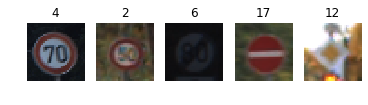

In [27]:
%matplotlib inline
import random
import matplotlib.pyplot as plt


num_samples = 5
indices = random.sample(range(X_test.shape[0] - 1), num_samples)
images = X_test[indices]/255
labels = y_test[indices]

for i in range(num_samples):
    plt.subplot(1,num_samples,i+1)
    plt.imshow(images[i])
    plt.title(labels[i])
    plt.axis('off')

prediction = tf_predictor.predict(images.reshape(num_samples, 32, 32, 3))['predictions']
prediction = np.array(prediction)
predicted_label = prediction.argmax(axis=1)
print('Predicted labels are: {}'.format(predicted_label))

In [28]:
tf_predictor.delete_endpoint()